## Cat or Dog classifier

In [ ]:
#Photo dataset originally from https://www.udemy.com/machinelearning/

In [2]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt  
import numpy as np

In [ ]:
#Let's take a look at some of the images first:

In [189]:
from keras.preprocessing import image
from pathlib import Path
import random

def show_images(n=4, predict=False, patht='train'):

    while n>0:
        path = Path('C:/Users/Ryan/GitHub/CatDog/data/'+patht+'/'+random.choice(['cats','dogs']))
        rand_image = random.choice(list(path.glob('*.jpg')))
        rand_image = image.load_img(rand_image, target_size=(64, 64))
        
        if predict:
            test_image = image.img_to_array(rand_image)
            test_image = np.expand_dims(test_image, axis = 0)
            result = model.predict(test_image)
            labels = {0:'cat', 1:'dog'}
            print('Predicted: ',labels[round(result[0][0])])
            
        display(rand_image)
        
        n -= 1

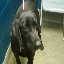

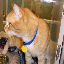

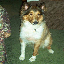

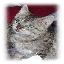

In [190]:
show_images()

In [3]:
#Building the model

'''
Start with smaller filters, increase in later layers. 
Include a dense/fully connected layer before final sigmoid/softmax
maybe include dropout if it looks like overfitting
'''

model = Sequential()

model.add(Conv2D(32, (3, 3), activation="relu", padding='same', input_shape=(64, 64, 3)))
model.add(Conv2D(32, (3, 3), padding='same', activation="relu"))
model.add(MaxPooling2D(pool_size = (2, 2)))

model.add(Conv2D(64, (3, 3), padding='same', activation="relu"))
model.add(Conv2D(64, (3, 3), padding='same', activation="relu"))
model.add(MaxPooling2D(pool_size = (2, 2)))

# model.add(Conv2D(128, (3, 3), activation="relu"))
# model.add(Conv2D(128, (3, 3), activation="relu"))
# model.add(MaxPooling2D(pool_size = (2, 2)))

model.add(Flatten())

model.add(Dense(activation = 'relu', units = 128))
model.add(Dropout(0.5))
model.add(Dense(activation = 'relu', units = 128))
model.add(Dropout(0.5))

model.add(Dense(activation = 'sigmoid', units = 1))

model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [9]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 64, 64, 32)        896       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 32, 32, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 16384)             0         
__________

In [4]:
#Setting up the data for training and testing

'''including some data augmentation:'''

batch_size = 100

train_gen = ImageDataGenerator(rescale = 1/255, 
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

test_gen = ImageDataGenerator(rescale = 1/255)    #Don't augment the test data, only the training data

train_data = train_gen.flow_from_directory('data/train',
                                           target_size = (64, 64),
                                           batch_size = batch_size,
                                           class_mode = 'binary')

test_data = test_gen.flow_from_directory('data/test', 
                                         target_size = (64, 64),
                                         batch_size = batch_size,
                                         class_mode = 'binary')

Found 8000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


In [6]:
#Training

'''
including earlystopping with excess epochs to prevent over/under fitting (probably reduce to patience=3 next time)
next time include model checkpoints callback too:

filepath = 'catdog.{epoch:02d}-{val_loss:.2f}.hdf5'
keras.callbacks.ModelCheckpoint(filepath, save_best_only=True, save_weights_only=False)
'''

train_size = train_data.n
test_size = test_data.n


history = model.fit_generator(train_data,
                             steps_per_epoch = train_size // batch_size,
                             epochs = 50,
                             validation_data = test_data,
                             validation_steps = test_size // batch_size,
                             callbacks = [EarlyStopping(monitor='val_loss', patience=5, verbose=1)]
                             )

Epoch 1/50
80/80 [==============================] - 269s 3s/step - loss: 0.6957 - acc: 0.5089 - val_loss: 0.6927 - val_acc: 0.5660
Epoch 2/50
80/80 [==============================] - 241s 3s/step - loss: 0.6866 - acc: 0.5497 - val_loss: 0.6796 - val_acc: 0.6190
Epoch 3/50
80/80 [==============================] - 243s 3s/step - loss: 0.6857 - acc: 0.5566 - val_loss: 0.6688 - val_acc: 0.5850
Epoch 4/50
80/80 [==============================] - 237s 3s/step - loss: 0.6782 - acc: 0.5803 - val_loss: 0.6478 - val_acc: 0.6440
Epoch 5/50
80/80 [==============================] - 246s 3s/step - loss: 0.6477 - acc: 0.6351 - val_loss: 0.6365 - val_acc: 0.6620
Epoch 6/50
80/80 [==============================] - 277s 3s/step - loss: 0.6068 - acc: 0.6784 - val_loss: 0.5898 - val_acc: 0.6885
Epoch 7/50
80/80 [==============================] - 277s 3s/step - loss: 0.5809 - acc: 0.6990 - val_loss: 0.5526 - val_acc: 0.7170
Epoch 8/50
80/80 [==============================] - 240s 3s/step - loss: 0.5440 - a

In [7]:
# save the model weights to disk, just in case

model.save("catdog.h5")
print("Saved model to disk")

Saved model to disk


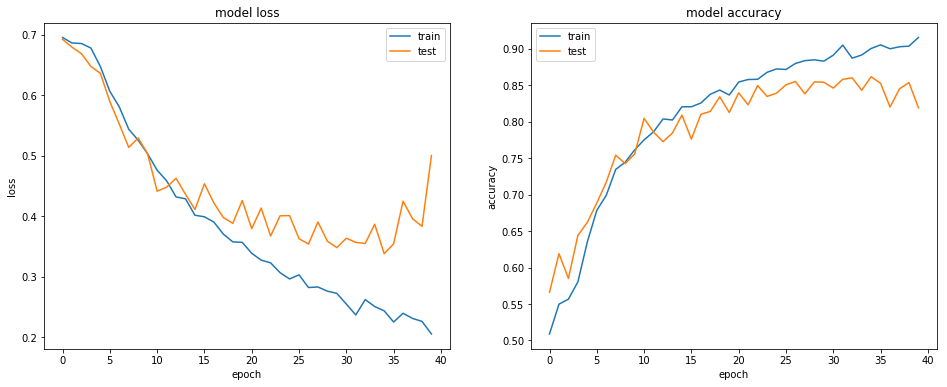

In [8]:
# plotting the training history

fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(16,6))

# loss history
ax0.plot(history.history['loss'])
ax0.plot(history.history['val_loss'])
ax0.set_title('model loss')
ax0.set_ylabel('loss')
ax0.set_xlabel('epoch')
ax0.legend(['train', 'test'], loc='upper right')

#accuracy history
ax1.plot(history.history['acc'])
ax1.plot(history.history['val_acc'])
ax1.set_title('model accuracy')
ax1.set_ylabel('accuracy')
ax1.set_xlabel('epoch')
ax1.legend(['train', 'test'], loc='upper left')

plt.show()

In [ ]:
#Can see definite divergence in train vs test loss around epoch 35, signalling overfitting

In [ ]:
#Let's visualise some predictions

Predicted:  dog


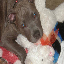

Predicted:  cat


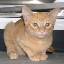

Predicted:  dog


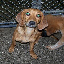

Predicted:  dog


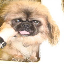

In [193]:
show_images(n=4, predict=True, patht='test')

In [ ]:
#possible improvements:

'''
Larger networksize, longer training
implement model checkpoints callback during training
Show confidence of predictions alongside images
Display low confidence images / incorrect classifications
'''